In [12]:
from PIL import Image

from montecarlo import LatticeMarkovChain
from lattice2d import LatticeGaugeTheory2D
from latticeoperators import *

In [13]:
# set to False to load saved Markov Chain configurations and plots, otherwise will run all cells fully
FULL_RUN = False

# Create a Markov Chain from a Lattice
Initially we will use an 8x8 lattice with $\beta = 4$, which is the default value.

In [14]:
lattice = LatticeGaugeTheory2D(8, 8)

## Choose a step size
In order to select a step size, we will run the metropolis algorithm for 50 steps for a number of different step sizes, to pick one with a desirable acceptance rate (50 - 60%):

In [15]:
step_sizes = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
for step_size in step_sizes:
    markov_chain = LatticeMarkovChain(lattice, step_size=step_size)
    _, acceptance_rate = markov_chain.run_metropolis(50, supress_output=True)
    print(f'Acceptance Rate for Step Size {step_size} is {acceptance_rate}')

Acceptance Rate for Step Size 0.01 is 0.6834375
Acceptance Rate for Step Size 0.05 is 0.65765625
Acceptance Rate for Step Size 0.1 is 0.63953125
Acceptance Rate for Step Size 0.2 is 0.5896875
Acceptance Rate for Step Size 0.3 is 0.52765625
Acceptance Rate for Step Size 0.4 is 0.47640625
Acceptance Rate for Step Size 0.5 is 0.410625


0.2 appears to be a reasonable acceptance rate. We will use this.


## Run Metropolis Algorithm on Markov Chain

Run for 5000 runs to produce a (hopefully) sufficiently long Markov Chain

In [16]:
if FULL_RUN:
    markov_chain = LatticeMarkovChain(lattice, step_size=0.2)
    markov_chain.run_metropolis(10000)
    markov_chain.save_configurations_to_file('data/mc10000_beta4_step_size0_2_lattice8x8.npy')
else:
    markov_chain.load_configurations_from_file('data/mc10000_beta4_step_size0_2_lattice8x8.npy')

Check that the expectation value of the lattice action $\langle S \rangle$ has converged. The Lattice Action is calculated by summing plaquettes over the whole lattice: $S = \sum_{\square}S_{\square}$, where $S_{\square} = \beta \left(1 - \frac{1}{2}\Re(\mathrm{Tr}(U_{ij}U_{jk}U_{kl}U_{li})\right)$ and the $U_{\mu\nu}$ are the SU(2) matrices sitting on the links of the lattice. The action will be calculated without errors at first, just to quickly see whether $\langle S \rangle$ has converged.

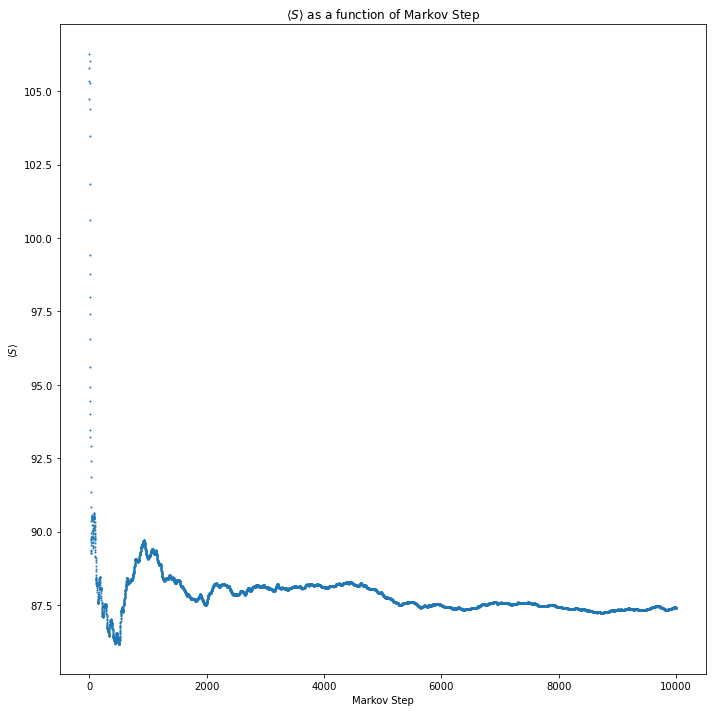

In [17]:
FULL_RUN=True
action_operator = LatticeActionOperator(lattice, markov_chain)
if FULL_RUN:
    plot_operator_exp_value_as_function_of_markov_step(action_operator, 
        r'$\langle S \rangle$ as a function of Markov Step', r'$\langle S \rangle$', 
        filepath='plots/action_no_error_mc10000_beta4_step_size0_2_lattice8x8.png')
else:
    im = Image.open('plots/action_no_error_mc10000_beta4_step_size0_2_lattice8x8.png')
    display(im)

## Remove Burn-In Steps

This appears to have converged rougly, there is quite a long burn in period, so the Markov steps 0 to 1750 will be removed. This is not strictly required for an infinite chain due to Berkhoff's ergodic theorem, as the chain will always produce the correct expectation value. However, we do not have an infinite chain, and the burn in period is just below 20% of the total Markov Chain so these steps should be excluded from calculations.

In [18]:
markov_chain.trim_first_n_steps(1750)

## Integrated Autocorrelation Function of Action Operator

Before we are able to plot error bars with the action, we need to obtain the integrated autocorrelation function to correct the variance estimates for correlated measurements (since in MCMC the configurations are correlated). The integrated autocorrelation function
$$\tau_{\langle S \rangle} = \sum^{\infty}_{\tau=-\infty} \rho_{\langle S \rangle}(\tau)$$
where $\rho_{\langle S \rangle}(\tau) = \frac{\frac{1}{N - \tau}\sum^{N - \tau}_{n=1}\left(S_n  - \langle S \rangle\right)\left(S_{n+\tau}  - \langle S \rangle\right)}{\frac{1}{N}\sum^{N}_{n=1}\left(S_n  - \langle S \rangle\right)^2} $ and $N$ is the size of the Markov Chain
is approximated by the sum:
$$\tau_{\langle S \rangle} = 1 + \frac{2}{\frac{1}{N}\sum^{N}_{n=1}\left(S_n  - \langle S \rangle\right)^2} \sum^{M}_{\tau=1} \frac{1}{N - \tau}\sum^{N - \tau}_{n=1}\left(S_n  - \langle S \rangle\right)\left(S_{n+\tau}  - \langle S \rangle\right)$$
Where $M << N$ is some value where the autocorrelation first reaches near zero, so that noise is not included in the estimation of the errors.

As such, here we must find the point where the autocorrelation goes towards zero.

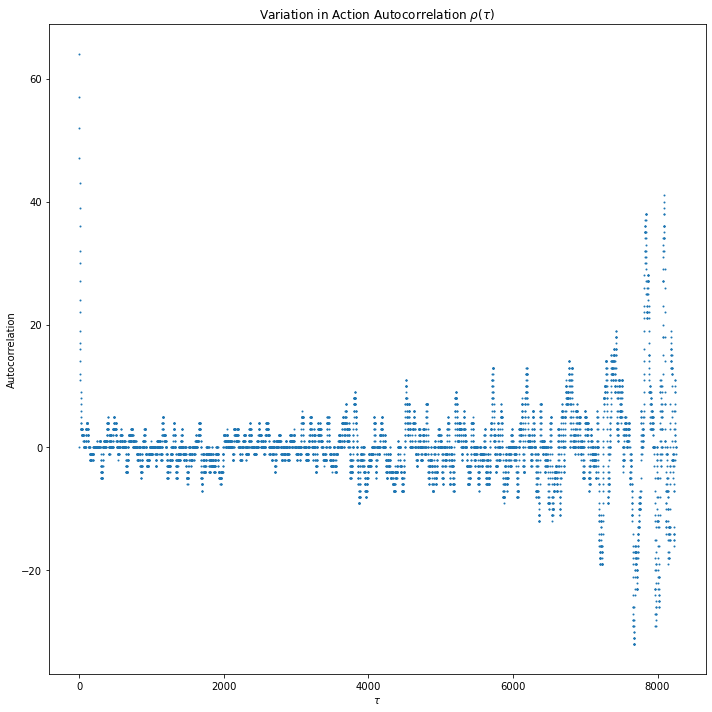

In [19]:
if FULL_RUN:
    plot_autocorrelation_as_func_of_tau(action_operator, 'Action', 
        'plots/autocorrelation_mc10000_beta4_step_size0_2_lattice8x8.png')
else:
    im = Image.open('plots/autocorrelation_mc10000_beta4_step_size0_2_lattice8x8.png')
    display(im)

This shows that the integrated autocorrelation sum can be calculated over a relatively short range, as most of the autocorrelation function is just noise. To pinpoint the exact point to stop at zoom into $\tau=[0,500]$

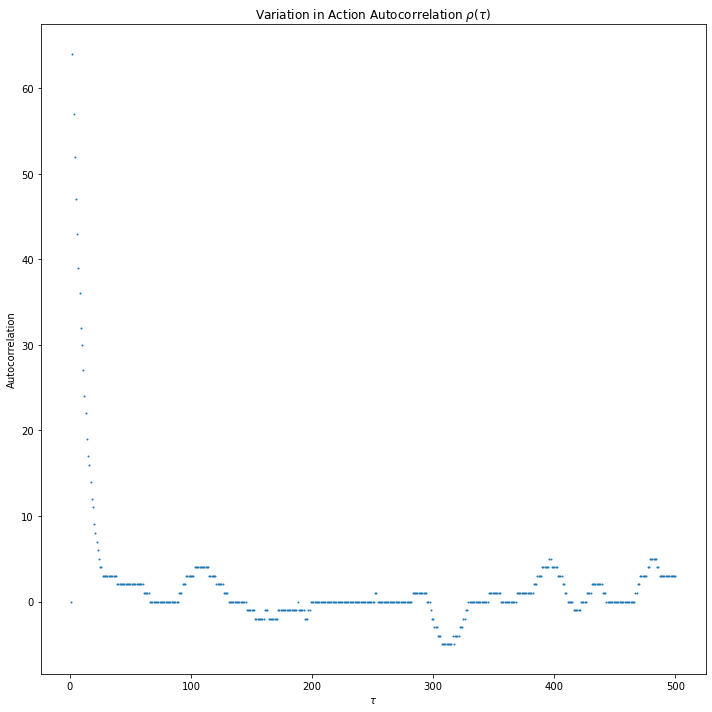

In [20]:
if FULL_RUN:
    plot_autocorrelation_as_func_of_tau(action_operator, 'Action', 
        'plots/autocorrelation_zoomed_mc10000_beta4_step_size0_2_lattice8x8.png', 500)
else:
    im = Image.open('plots/autocorrelation_zoomed_mc10000_beta4_step_size0_2_lattice8x8.png')
    display(im)

To avoid the error estimation containing noise, the integrated autocorrelation will be estimated using a sum of autocorrelations from $\tau=1$ to $\tau=60$.

In [21]:
action_operator.set_sum_to_for_integrated_autocorrelation(60)

## Plot the Action and Errors

Now that the errors can be calculated properly, since the integrated autocorrelation can now be estimated correctly, we can plot the expectation value of the action with proper error bars.

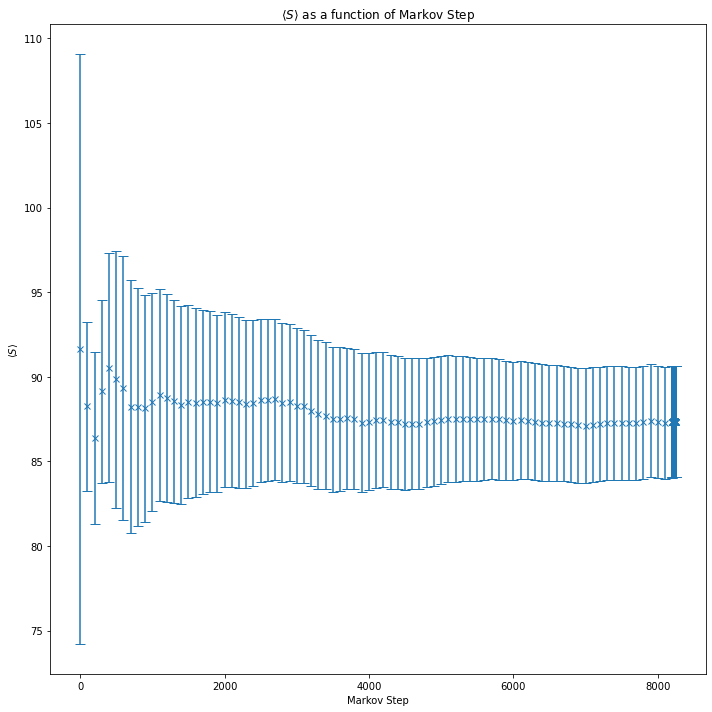

In [22]:
if FULL_RUN:
    plot_operator_exp_value_as_function_of_markov_step(action_operator, 
        r'$\langle S \rangle$ as a function of Markov Step', r'$\langle S \rangle$', 
        filepath='plots/action_exp_mc10000_beta4_step_size0_2_lattice8x8.png', 
        error_bars=True, sparsity=127/128)
else:
    im = Image.open('plots/action_exp_mc10000_beta4_step_size0_2_lattice8x8.png')
    display(im)